In [147]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
from mesa import Agent, Model

# Con ''RandomActivation'' hacemos que todos los agentes se activen al mismo tiempo
from mesa.time import RandomActivation

# Utilizaremos ''DataCollector'' para obtener información de cada paso de la simulación
from mesa.datacollection import DataCollector

# matplotlib se usa para crear la animación
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

#Importamos los siguientes paquetes para el mejor manejo de valores numéricos
import numpy as np
import pandas as pd

In [148]:
#Los semáforos que usaremos
class Semaforo(Agent):
    def __init__(self, model):
        
        #Al principio empieza con luz roja
        self.light = False
        


In [149]:
# Agente de la caja de control
class CajaControl(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
        self.contarCarros()
        self.cambiarSemaforoLuz()
        self.timer = 10
        
    def step(self):
        self.contarCarros()
        
        if self.timer == 0:
            self.cambiarSemaforoLuz()
            self.timer = 10
            
        self.timer -= 1
        
            
    # Cambia el color del semáforo a verde dependiendo de cuantos carros haya
    def cambiarSemaforoLuz(self):
        if(self.cont_norte == max(self.cont_norte,max(self.cont_sur,max(self.cont_este,self.cont_oeste)))):
            self.model.semNorte.light = True            
            self.model.semEste.light = False
            self.model.semOeste.light = False
            self.model.semSur.light = False       
        
        elif(self.cont_este == max(self.cont_norte,max(self.cont_sur,max(self.cont_este,self.cont_oeste)))):
            self.model.semNorte.light = False            
            self.model.semEste.light = True
            self.model.semOeste.light = False
            self.model.semSur.light = False
        
        elif(self.cont_oeste == max(self.cont_norte,max(self.cont_sur,max(self.cont_este,self.cont_oeste)))):
            self.model.semNorte.light = False            
            self.model.semEste.light = False
            self.model.semOeste.light = True
            self.model.semSur.light = False
             
        elif(self.cont_sur == max(self.cont_norte,max(self.cont_sur,max(self.cont_este,self.cont_oeste)))):
            self.model.semNorte.light = False            
            self.model.semEste.light = False
            self.model.semOeste.light = False
            self.model.semSur.light = True
            
    
    # Cuenta los carros de cada fila  
    def contarCarros(self):
        self.cont_norte = 0
        self.cont_sur = 0
        self.cont_este = 0
        self.cont_oeste = 0
        
        for agent in self.model.schedule.agents:
            if agent.orientation == 'inicioNorte':
                self.cont_norte += 1
                
            elif agent.orientation == 'inicioSur':
                self.cont_sur += 1
                
            elif agent.orientation == 'inicioEste':
                self.cont_este += 1
                
            elif agent.orientation == 'inicioOeste':
                self.cont_oeste += 1 

In [150]:
#Los carros dentro de la simulación
class Carro(Agent):
    def __init__(self, unique_id, model, x, y, orientation):
        super().__init__(unique_id, model)
        
        #Posición del carro
        self.position = np.array((x,y), dtype=np.float64)
        
        #Orientación del carro
        self.orientation = orientation
        
        #Vector de velocidad y aceleración del coche
        self.check_speed()
        
        # Máxima distancia entre coches
        self.MAX_DIST = 1
        
        #variables para la vuelta
        self.index = 0
        self.turn = False
        
    def step(self):
        self.check_speed()
        
        if self.frenar() == False:
            self.check_turn()
            if self.turn == True:
                if self.index < len(self.curve):
                    self.position = self.curve[self.index]
                    self.index += 1
                else:
                    self.turn = False
                    self.index = 0
            elif self.turn == False:
                self.position = self.position + self.velocity
            
        #self.check_distance()
        
    # Define la velocidad de los coches y su dirección
    def check_speed(self):
        # Horizontal de derecha a izquierda
        if self.orientation == 'inicioEste':
            vel = -1
            #acc = vel/2
            self.velocity = np.array((vel, 0), dtype=np.float64)
            #self.acceleration = np.array((acc, 0), dtype=np.float64)
            
        # Vertical de arriba hacia abajo
        elif self.orientation == 'inicioNorte':
            vel = -1
            #acc = vel/2
            self.velocity = np.array((0, vel), dtype=np.float64)
            #self.acceleration = np.array((0, acc), dtype=np.float64)
        
        # Horizontal de izquierda a derecha
        elif self.orientation == 'inicioOeste':
            vel = 1
            #acc = vel/2
            self.velocity = np.array((vel, 0), dtype=np.float64)
            #self.acceleration = np.array((acc, 0), dtype=np.float64)
            
        # Vertical de abajo hacia arriba
        elif self.orientation == 'inicioSur':
            vel = 1
            #acc = vel/2
            self.velocity = np.array((0, vel), dtype=np.float64)
            #self.acceleration = np.array((0, acc), dtype=np.float64)
    
    # Hace que frenen los coches si el semáforo está en rojo
    def frenar(self):
        if self.orientation == 'inicioEste' and self.position.flatten()[0] == 3: 
            if model.semEste.light == False:
                return True
            
        elif self.orientation == 'inicioNorte' and self.position.flatten()[1] == 3:
            if model.semNorte.light == False:
                return True
            
        elif self.orientation == 'inicioOeste' and self.position.flatten()[0] == -3:
            if model.semOeste.light == False:
                return True
            
        elif self.orientation == 'inicioSur' and self.position.flatten()[1] == -3:
            if model.semSur.light == False:
                return True
        
        return False
    
    
    # Revisa la distancia entre los coches para ecitar coaliciones
    def check_distance(self):
        for agent in model.schedule.agents:
            if np.linalg.norm(agent.position - self.position) < self.MAX_DIST:
                self.position = self.position - self.velocity
    
    # Permite que el coche gire a la derecha o a la izquierda
    def check_turn(self):
        choice = np.random.choice([True,False])
        
        # Vuelta a la derecha
        if self.orientation == 'inicioEste' and self.position.flatten()[0] == 3 and self.position.flatten()[1] == 2: 
            if choice == True:
                self.curve = np.array([[2.68,2.05], [2.4,2.17], [2.2,2.39], [2.06,2.67]])
                self.turn = True
                self.orientation = 'inicioSur'
            
        elif self.orientation == 'inicioSur' and self.position.flatten()[0] == 2 and self.position.flatten()[1] == -3: 
            if choice == True:
                self.curve = np.array([[2.05,-2.7], [2.22,-2.42], [2.45,-2.23], [2.72,-2.06]])
                self.turn = True
                self.orientation = 'inicioOeste'
            
        elif self.orientation == 'inicioOeste' and self.position.flatten()[0] == -3 and self.position.flatten()[1] == -2: 
            if choice == True:
                self.curve = np.array([[-2.7,-2.08], [-2.46,-2.26], [-2.26,-2.47], [-2.11,-2.73]])
                self.turn = True
                self.orientation = 'inicioNorte'
            
        elif self.orientation == 'inicioNorte' and self.position.flatten()[0] == -2 and self.position.flatten()[1] == 3: 
            if choice == True:
                self.curve = np.array([[-2.05,2.7], [-2.22,2.42], [-2.45,2.23], [-2.72,2.06]])
                self.turn = True
                self.orientation = 'inicioEste'
        
        # Vuelta izquierda
        if self.orientation == 'inicioEste' and self.position.flatten()[0] == 3 and self.position.flatten()[1] == 0:
            self.curve = np.array([[2.38,-0.24], [1.74,-0.5], [1.01,-0.8], [0.32,-1.21], [-0.27,-1.65], [-0.81,-2.09], [-1.41,-2.54]])
            self.turn = True
            self.orientation = 'inicioNorte'
                
        elif self.orientation == 'inicioNorte' and self.position.flatten()[0] == 0 and self.position.flatten()[1] == 3:
            self.curve = np.array([[0.21,2.39], [0.53,1.78], [0.83,1.15], [1.19,0.42], [1.7,-0.29], [2.05,-0.93], [2.5,-1.5]])
            self.turn = True
            self.orientation = 'inicioOeste'
                
        elif self.orientation == 'inicioOeste' and self.position.flatten()[0] == -3 and self.position.flatten()[1] == 0:
            self.curve = np.array([[-2.38,0.24], [-1.74,0.5], [-1.01,0.8], [-0.32,1.21], [0.27,1.65], [0.81,2.09], [1.41,2.54]])
            self.turn = True
            self.orientation = 'inicioSur'
                
        elif self.orientation == 'inicioSur' and self.position.flatten()[0] == 0 and self.position.flatten()[1] == -3:
            self.curve = np.array([[-0.21,-2.39], [-0.53,-1.78], [-0.83,-1.15], [-1.19,-0.42], [-1.7,0.29], [-2.05,0.93], [-2.5,1.5]])
            self.turn = True
            self.orientation = 'inicioEste'

In [151]:
# Obtiene el número de coches existentes
def totalCarros(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

# Inicializa el modelo
class CarroModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        
        self.inicioSemaforos()
        self.control = CajaControl(1, self)
        
        self.id = 8
        
        #Mod!!!
        self.source = np.array([[10, 1], [10, 3], [-1, 10], [-3, 10], [-10, 0], [-10, -2], [0, -10], [2, -10]])
        #self.source = np.array([[10, 1], [10, 3], [-1, 10], [-3, 10], [-10, 0], [-10, -2], [0, -10], [2, -10]])
        temp = []
        i = 0
        
        while i in range(8):
            pos = np.random.randint(8)
            
            if pos in temp:
                continue
            
            x = self.source[pos][0]
            y = self.source[pos][1]
            orientation = self.orientacionInicial(pos)
            car = Carro(i, self, x, y, orientation)
            self.schedule.add(car)
            temp.append(pos)
            i += 1

            
        self.datacollector = DataCollector(model_reporters = {"Carros" : totalCarros})
            
    
    def step(self):
        if self.id < self.num_agents:
            pos = np.random.randint(8)
            x = self.source[pos][0]
            y = self.source[pos][1]
            orientation = self.orientacionInicial(pos)
            car = Carro(self.id, self, x, y, orientation)
            self.schedule.add(car)
            self.id += 1
        
        self.datacollector.collect(self)
        self.schedule.step()
        self.control.step()
    
    
    # Obtiene la orientación con la que inicia el coche
    def orientacionInicial(self, pos):
        if 0 <= pos <= 1:
            return 'inicioEste'
        
        elif 2 <= pos <= 3:
            return 'inicioNorte'
        
        elif 4 <= pos <= 5:
            return 'inicioOeste'
        
        elif 6 <= pos <= 7:
            return 'inicioSur'
    
    
    #Pone los semáforos  
    def inicioSemaforos(self):
        self.semNorte = Semaforo(self)
        self.semSur = Semaforo(self)
        self.semEste = Semaforo(self)
        self.semOeste = Semaforo(self)

In [156]:
DURACION = 85
N = 14
model = CarroModel(N)

for i in range(DURACION):
    model.step()

In [157]:
carretera = model.datacollector.get_model_vars_dataframe()

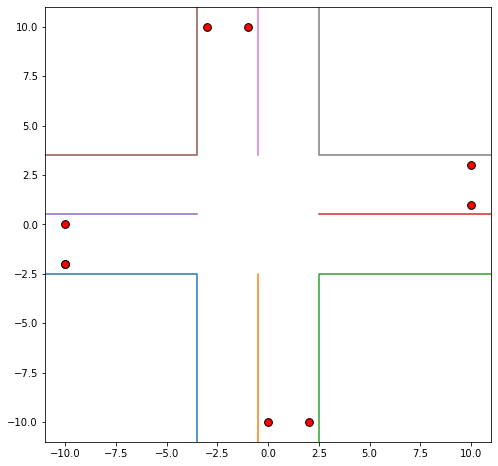

In [158]:
fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(carretera.iloc[0][0][:,0], carretera.iloc[0][0][:,1],
                     s=60, cmap="jet", color="r", edgecolor="k", marker="o")

ax.axis([-11, 11, -11, 11])

plt.plot([-3.5, -3.5, -11], [-11, -2.5, -2.5])
plt.plot([-0.5, -0.5], [-11, -2.5])
plt.plot([2.5, 2.5, 11], [-11, -2.5, -2.5])
plt.plot([2.5, 11], [0.5, 0.5])
plt.plot([-3.5, -11], [0.5, 0.5])
plt.plot([-3.5, -3.5, -11], [11, 3.5, 3.5])
plt.plot([-0.5, -0.5], [11, 3.5])
plt.plot([2.5, 2.5, 11], [11, 3.5, 3.5])

def update(frame_number):
    
    scatter.set_offsets(all_positions.iloc[frame_number][0])    
    return scatter

anim = animation.FuncAnimation(fig, update, frames = DURACION)

In [160]:
anim